In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random
import glob
import cv2
import time

import torchvision
import torch
from torchvision.models import vgg16
from torch.utils.tensorboard import SummaryWriter
from torch import nn
from torch.utils.data import DataLoader

#       Create Train, Valid and Test sets
Please put *Linnaeus 5 256X256* folder under your google drive directory

Reference: https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895

In [ ]:
train_data_path = './drive/My Drive/Linnaeus 5 256X256/train'
test_data_path = './drive/My Drive/Linnaeus 5 256X256//test'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

# 1. get all the paths from train_data_path and append image paths and class to to respective lists
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

# 2. split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):]

# 3. create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))


train_image_path example:  ./drive/My Drive/Linnaeus 5 256X256/train/berry/161_256.jpg
class example:  berry
Train size: 4888
Valid size: 1222
Test size: 2010


In [ ]:
# Create dictionary for class indexes
class_to_idx = {'berry': 0, 'bird': 1, 'dog': 2, 'flower': 3, 'other': 4}

# Load Dataset
Ref: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [ ]:
from torch.utils.data import Dataset
class Linnaeus5Dataset(Dataset):
    def __init__(self, image_paths, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

transform = torchvision.transforms.ToTensor()
train_data = Linnaeus5Dataset(train_image_paths, transform=transform)
valid_data = Linnaeus5Dataset(valid_image_paths, transform=transform)
test_data = Linnaeus5Dataset(test_image_paths, transform=transform)

In [ ]:
train_data_size = len(train_data)
valid_data_size = len(valid_data)
test_data_size = len(test_data)

train_dataloader = DataLoader(train_data, batch_size=64)
valid_dataloader = DataLoader(valid_data, batch_size=64)

# Instantiate a pre-trained VGG16 model
network = vgg16(pretrained=True)

# Add an adaptive average pooling layer before the classifier
network.avgpool = nn.AdaptiveAvgPool2d((7, 7))

# Replace the final layer with a new linear layer for 5 classes
num_classes = 5
network.classifier[6] = nn.Linear(4096, num_classes)

rank = 10

# Modify the first fully connected layer
network.classifier[0] = nn.Sequential(
    nn.Linear(25088, rank),
    nn.Linear(rank, 4096)
)

# Modify the second fully connected layer
network.classifier[3] = nn.Sequential(
    nn.Linear(4096, rank),
    nn.Linear(rank, 4096)
)

if torch.cuda.is_available():
    network = network.cuda()

loss_fn = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    loss_fn = loss_fn.cuda()

learning_rate = 1e-2
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)


epoch = 30

train_losses = []
valid_losses = []
valid_accuracies = []

start_time = time.time()

for i in range(epoch):
    print("------Epoch-{}------".format(i+1))

    # Train
    network.train()
    cumulative_train_loss = 0
    total_samples = 0
    for data in train_dataloader:
        imgs, targets = data
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            targets = targets.cuda()
        outputs = network(imgs)
        loss = loss_fn(outputs, targets)

        # Optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update cumulative_train_loss and total_samples
        cumulative_train_loss += loss.item() * imgs.size(0)
        total_samples += imgs.size(0)

    # Calculate average training loss
    average_train_loss = cumulative_train_loss / total_samples
    print("Train Loss: {}".format(average_train_loss))
    train_losses.append(average_train_loss)

    # Valid
    network.eval()
    cumulative_valid_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for data in valid_dataloader:
            imgs, targets = data
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                targets = targets.cuda()
            outputs = network(imgs)
            loss = loss_fn(outputs, targets)
            cumulative_valid_loss += loss.item() * imgs.size(0)
            accuracy = (outputs.argmax(1) == targets).sum()
            total_accuracy += accuracy

    average_valid_loss = cumulative_valid_loss / valid_data_size
    valid_accuracy = total_accuracy.item() / valid_data_size

    print("Valid Loss: {}".format(average_valid_loss))
    print("Valid Accuracy: {}".format(valid_accuracy))

    valid_losses.append(average_valid_loss)
    valid_accuracies.append(valid_accuracy)


elapsed_time = time.time() - start_time
print("Total training time: {:.2f} seconds".format(elapsed_time))
torch.save(network, "/content/drive/MyDrive/network_VGG_lowrank.pth")
print("OK")


------Epoch-1------
Train Loss: 0.8524989450133958
Valid Loss: 0.1287088186598521
Valid Accuracy: 0.9639934533551555
------Epoch-2------
Train Loss: 0.406686537870116
Valid Loss: 0.21810176821635904
Valid Accuracy: 0.9492635024549918
------Epoch-3------
Train Loss: 0.08612669532228438
Valid Loss: 0.15535595354746223
Valid Accuracy: 0.9549918166939444
------Epoch-4------
Train Loss: 0.0284153978940886
Valid Loss: 0.15432379876292632
Valid Accuracy: 0.9664484451718495
------Epoch-5------
Train Loss: 0.012800169355977546
Valid Loss: 0.16026176526865882
Valid Accuracy: 0.9705400981996727
------Epoch-6------
Train Loss: 0.0035736289388064216
Valid Loss: 0.15601261172278744
Valid Accuracy: 0.9689034369885434
------Epoch-7------
Train Loss: 0.0012136464736080667
Valid Loss: 0.15981108155071044
Valid Accuracy: 0.9713584288052373
------Epoch-8------
Train Loss: 0.0005423328473777418
Valid Loss: 0.17227569261471298
Valid Accuracy: 0.9713584288052373
------Epoch-9------
Train Loss: 0.000396631078

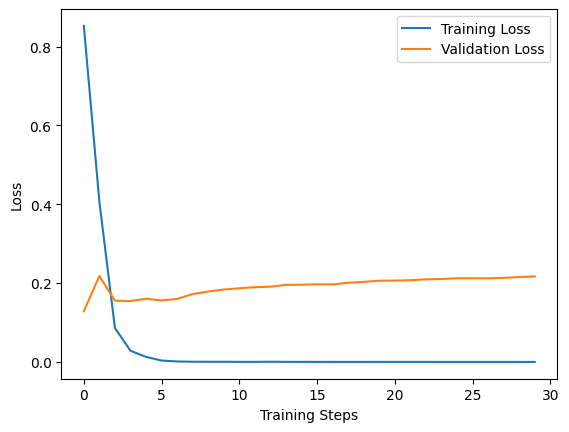

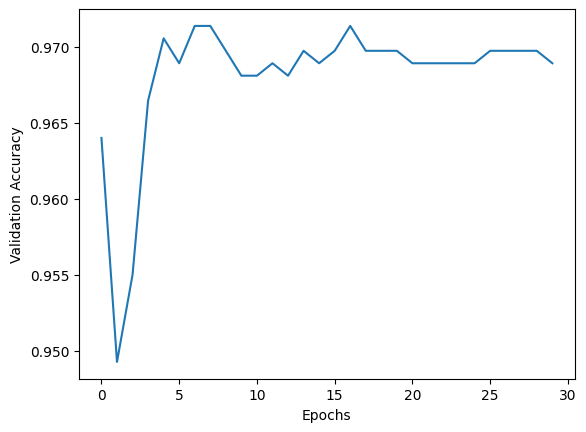

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure()
plt.plot(valid_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

In [ ]:
print(train_losses)
print("aaaaaa")
print(valid_losses)
print("aaaaaa")
print(valid_accuracies)

[0.8524989450133958, 0.406686537870116, 0.08612669532228438, 0.0284153978940886, 0.012800169355977546, 0.0035736289388064216, 0.0012136464736080667, 0.0005423328473777418, 0.0003966310787871678, 0.000385072952847655, 0.00022946549316804548, 0.00021353901949308263, 0.0005004973059012642, 0.00020112129027475854, 0.00013836102960685553, 0.000133001937194002, 0.00011784614471193467, 0.0001048322172168058, 8.290886363326957e-05, 9.103926227303887e-05, 7.468437420007271e-05, 6.792977129182749e-05, 7.40710389100163e-05, 6.12263615033456e-05, 6.773974650901755e-05, 5.995537162003758e-05, 4.910443762047744e-05, 6.121165239289876e-05, 4.684669543114721e-05, 4.379617906656029e-05]
aaaaaa
[0.1287088186598521, 0.21810176821635904, 0.15535595354746223, 0.15432379876292632, 0.16026176526865882, 0.15601261172278744, 0.15981108155071044, 0.17227569261471298, 0.1785903010035693, 0.18382106443376275, 0.18687529230273883, 0.1896428999455978, 0.19091075417965211, 0.19550194481537111, 0.19593177738244327, 0

In [ ]:
!nvidia-smi

Tue May  2 01:28:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    29W /  70W |  12799MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------